In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/skin-cancer-mnist-ham10000


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 304s 997ms/step - accuracy: 0.6433 - loss: 0.1795 - val_accuracy: 0.7444 - val_loss: 0.1065 - learning_rate: 1.0000e-04
Epoch 2/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 156s 622ms/step - accuracy: 0.7352 - loss: 0.1035 - val_accuracy: 0.7843 - val_loss: 0.0835 - learning_rate: 1.0000e-04
Epoch 3/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 154s 615ms/step - accuracy: 0.7867 - loss: 0.0775 - val_accuracy: 0.8073 - val_loss: 0.0727 - learning_rate: 1.0000e-04
Epoch 4/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 624ms/step - accuracy: 0.8036 - loss: 0.0674 - val_accuracy: 0.7933 - val_loss: 0.0731 - learning_rate: 1.0000e-04
Epoch 5/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 158s 628ms/step - accuracy: 0.8307 - loss: 0.0554 - val_accuracy: 0.7983 - val_loss: 0.0688 - learning_rate: 1.0000e-04
Epoch 6/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 157s 626ms/step - accuracy: 0.8566 - loss: 0.0451 - val_accuracy: 0.7868 - val_loss: 0.0727 - learning_rate: 1.0000e-04
Epoch 7/30
251/251 ━━━━━━━━━━━━━━━━━━━━ 

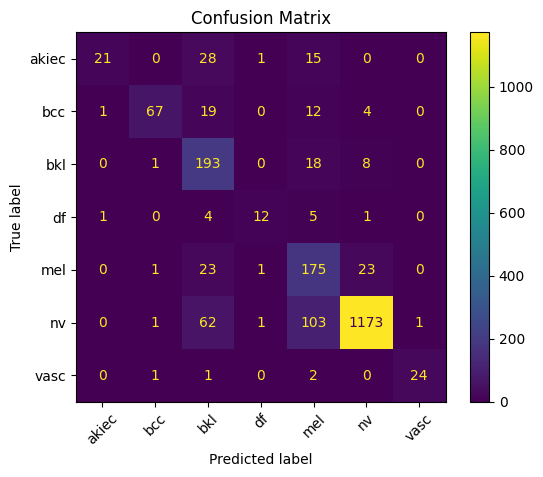

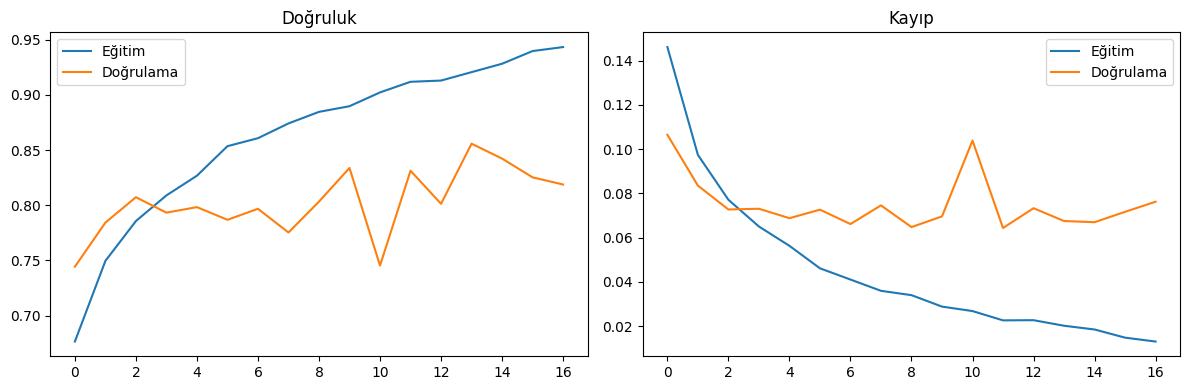

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras import backend as K

# === 0. Focal Loss Fonksiyonu ===
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

# === 1. Veri Yolları ===
dataset_path = "/kaggle/input/skin-cancer-mnist-ham10000"
image_dir1 = os.path.join(dataset_path, "HAM10000_images_part_1")
image_dir2 = os.path.join(dataset_path, "HAM10000_images_part_2")
metadata_path = os.path.join(dataset_path, "HAM10000_metadata.csv")

# === 2. Metadata ve Görsellerin Yolu ===
df = pd.read_csv(metadata_path)

def find_image_path(image_id):
    path1 = os.path.join(image_dir1, image_id + ".jpg")
    path2 = os.path.join(image_dir2, image_id + ".jpg")
    return path1 if os.path.exists(path1) else path2 if os.path.exists(path2) else None

df['image_path'] = df['image_id'].apply(find_image_path)
df = df[df['image_path'].notnull()]
df['label_name'] = df['dx']

# === 3. Eğitim ve Doğrulama Ayırımı ===
train_df, val_df = train_test_split(
    df, test_size=0.2, stratify=df['label_name'], random_state=42
)

# === 4. Parametreler ve Data Augmentation ===
IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='label_name',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='image_path',
    y_col='label_name',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === 5. EfficientNetB0 + Fine-tuning ===
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = True

# İlk 100 katmanı dondur
for layer in base_model.layers[:100]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(len(train_gen.class_indices), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# === 6. Derleme (Focal Loss) ===
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=focal_loss(gamma=2., alpha=0.25),
    metrics=['accuracy']
)

# === 7. Callbacks ===
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(factor=0.3, patience=3, verbose=1)

# === 8. Eğitim ===
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

# === 9. Değerlendirme ===
val_gen.reset()
y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = val_gen.classes
target_names = list(val_gen.class_indices.keys())

print(classification_report(y_true, y_pred, target_names=target_names))

# === 10. Confusion Matrix ===
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()

# === 11. Grafikler ===
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim')
plt.plot(history.history['val_accuracy'], label='Doğrulama')
plt.title('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim')
plt.plot(history.history['val_loss'], label='Doğrulama')
plt.title('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save("skin_cancer_detection_model.h5")


In [ ]:
import tensorflow as tf

# Eğer hata almadan başka bir ortamda yüklenebiliyorsa:
model = tf.keras.models.load_model('/content/skin_cancer_detection_model.h5', compile=False)

# .keras formatında yeniden kaydet
model.save('skin_cancer_model.keras', save_format='keras')
